In [1]:
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors as c
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
import numpy as np
from astropy.time import Time
import pandas as pd
from astropy.visualization.wcsaxes import add_beam, add_scalebar
from matplotlib import rcParams


In [2]:
hdul= fits.open('./mwpan2_RGB_3600.fits')
hdr = hdul[0].header
dat = hdul[0].data
hdul.close()

In [3]:
w = WCS(hdr)
w

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-CAR'  'GLAT-CAR'  'LINEAR'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 1800.950026799  900.950013387949  0.0  
CD1_1 CD1_2 CD1_3  : -0.099999998509884  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  0.099999998509884  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  1.0  
NAXIS : 3600  1800  3

(0.0, 1800.0)

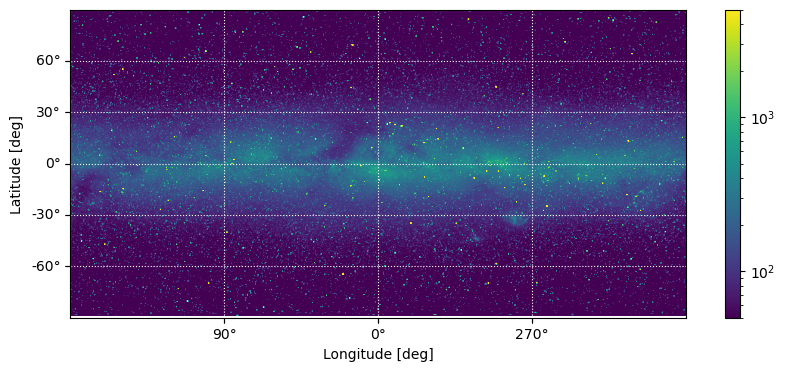

In [4]:
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(projection=w, slices=('x','y',0))
ax.coords.grid(True, color='white', ls='dotted')
plt.imshow(dat[0],norm=c.LogNorm(vmin=50,vmax=5e3))
plt.colorbar()
ax.set_ylabel('Latitude [deg]')
ax.set_xlabel('Longitude [deg]')
ax.set_xlim([0,3600])
ax.set_ylim([0,1800])

In [5]:
crlong, crlat = hdr['CRPIX1'], hdr['CRPIX2']
cdelt = hdr['CD2_2']

range_deg = 30
range_pix = range_deg/cdelt

In [6]:
srcCoord = SkyCoord('17h45m40.04s', '-29d00m28.1s', frame='icrs')

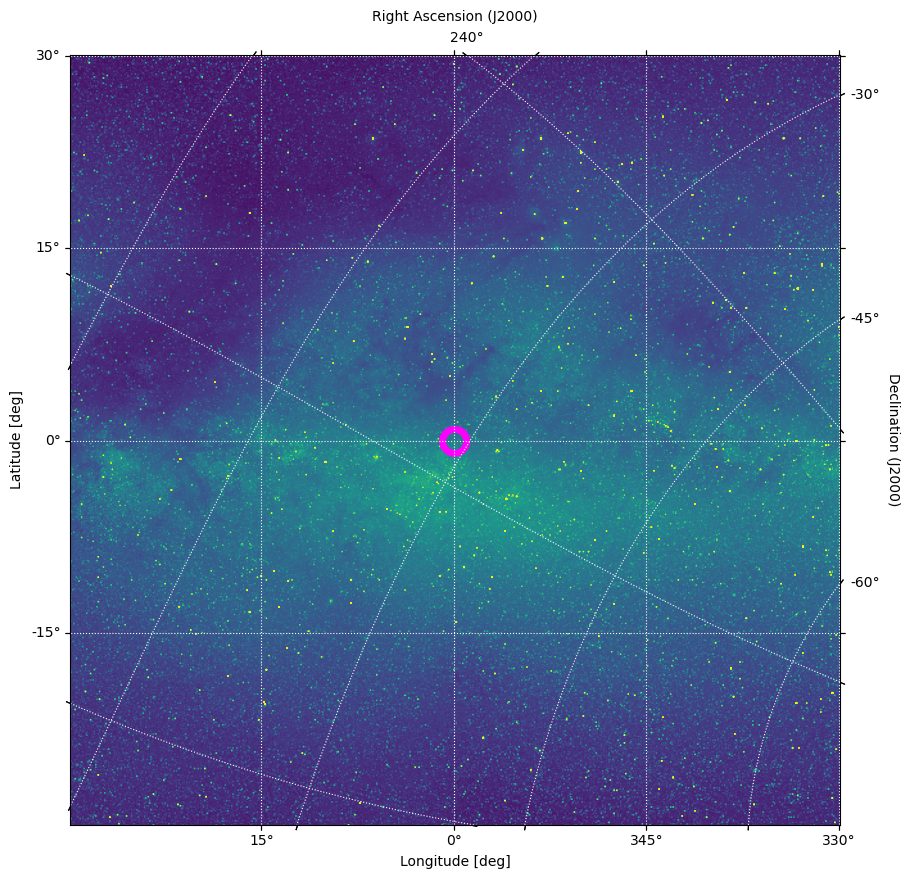

In [7]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=w, slices=('x','y',0))
ax.coords.grid(True, color='white', ls='dotted')
plt.imshow(dat[0],norm=c.LogNorm(vmin=50,vmax=5e3))
# plt.colorbar()
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_xlim([crlong-range_pix,crlong+range_pix])
ax.set_ylim([crlat-range_pix,crlat+range_pix])

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')

ax.scatter(srcCoord.ra, srcCoord.dec, transform=ax.get_transform('fk5'), s=300,
           edgecolor='magenta', facecolor='none',linewidth=5)

Now plot the path of the beam on the sky

- beam points at the meridian, az=180deg
- max alt is approximately 23d06m10s
- in ~24 hours trace a full circle at that alt

In [8]:
loc = EarthLocation.from_geodetic(lon='-78d41m34.92s', lat='37d52m41.35s',height=566)
# loc

In [9]:
## one day
utcoffset = -4*u.hour  # Eastern Daylight
obstime=Time('2024-01-01 00:00') + np.linspace(0,24,(24*3600)+1)*u.hour - utcoffset
target_altaz = srcCoord.transform_to(AltAz(obstime=obstime, location=loc))
x = np.where(target_altaz.alt == max(target_altaz.alt))

In [10]:
pointing_alt = target_altaz.alt[x]
pointing_az = target_altaz.az[x]
print("pointing:")
pointing_alt,pointing_az

pointing:


(<Latitude [23.10412046] deg>, <Longitude [180.00042098] deg>)

In [11]:
mytimes=Time('2024-01-01 00:00') + np.linspace(0,24,(24*20)+1)*u.hour - utcoffset

In [12]:
AltAz(az=pointing_az, alt=pointing_alt,location=loc,obstime=obstime[x]).transform_to(srcCoord)

<ICRS Coordinate: (ra, dec) in deg
    [(266.41683333, -29.00780556)]>

In [13]:
ras = []
decs = []
lons = []
lats = []

In [14]:
for t in range(len(mytimes)):
    i = AltAz(az=pointing_az, alt=pointing_alt,location=loc,obstime=mytimes[t]).transform_to(srcCoord)
    g = AltAz(az=pointing_az, alt=pointing_alt,location=loc,obstime=mytimes[t]).transform_to(srcCoord.transform_to('galactic'))
    ras = np.append(ras,i.ra[0].value)
    decs = np.append(decs,i.dec[0].value)
    lons = np.append(lons, g.l[0].value)
    lats = np.append(lats,g.b[0].value)

In [15]:
# plt.plot(lons,lats)

In [16]:
# range_pix = range_pix*2

In [17]:
w

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-CAR'  'GLAT-CAR'  'LINEAR'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 1800.950026799  900.950013387949  0.0  
CD1_1 CD1_2 CD1_3  : -0.099999998509884  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  0.099999998509884  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  1.0  
NAXIS : 3600  1800  3

In [18]:
from matplotlib.patches import Circle, Rectangle
from astropy.visualization.wcsaxes import Quadrangle

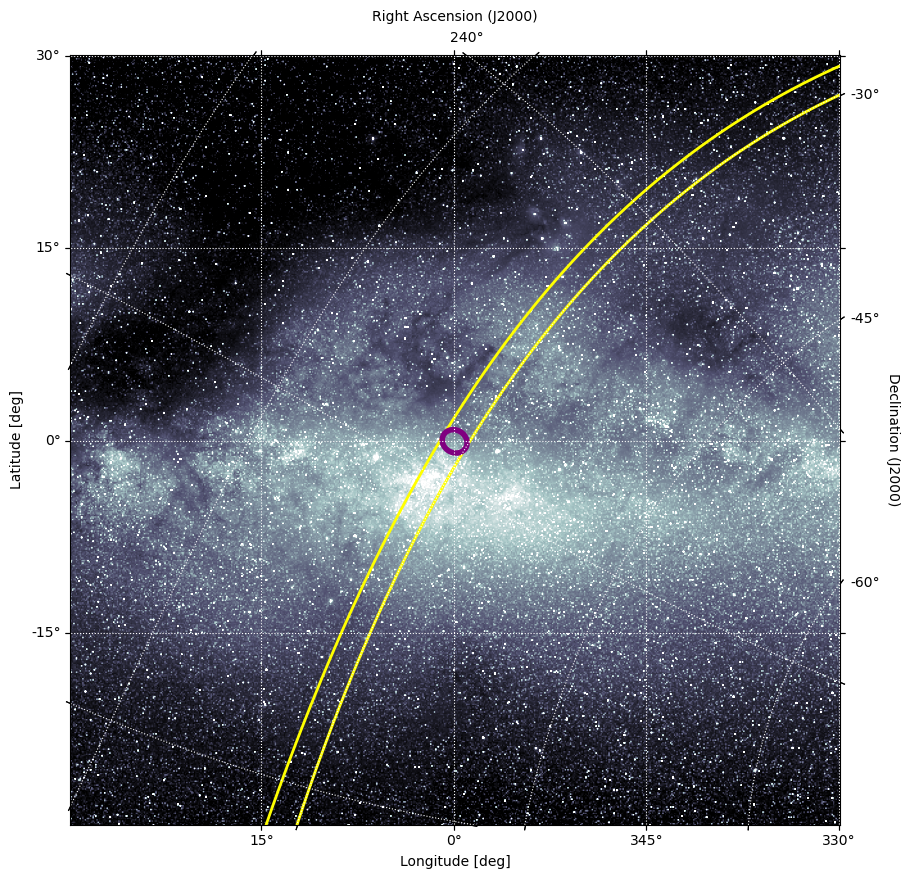

In [19]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=w, slices=('x','y',0))
ax.coords.grid(True, color='white', ls='dotted')
plt.imshow(dat[0],norm=c.LogNorm(vmin=80,vmax=.8e3),cmap='bone')
# plt.colorbar()
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_xlim([crlong-range_pix,crlong+range_pix])
ax.set_ylim([crlat-range_pix,crlat+range_pix])

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')


# ax.scatter(ras, decs, transform=ax.get_transform('fk5'), s=50,
#            facecolor='white')

# ax.scatter(srcCoord.ra, srcCoord.dec, transform=ax.get_transform('fk5'), s=300,
#            edgecolor='red', facecolor='none',linewidth=5)

r = Quadrangle((srcCoord.ra.value-50,srcCoord.dec.value-1)*u.deg, 90*u.deg, 2*u.deg,
               edgecolor='yellow', facecolor='none', linewidth=2,
               transform=ax.get_transform('fk5'))
ax.add_patch(r)

circ = Circle((srcCoord.ra.value,srcCoord.dec.value), 1, edgecolor='purple',
                facecolor='none',transform=ax.get_transform('fk5'),linewidth=4)
ax.add_patch(circ)


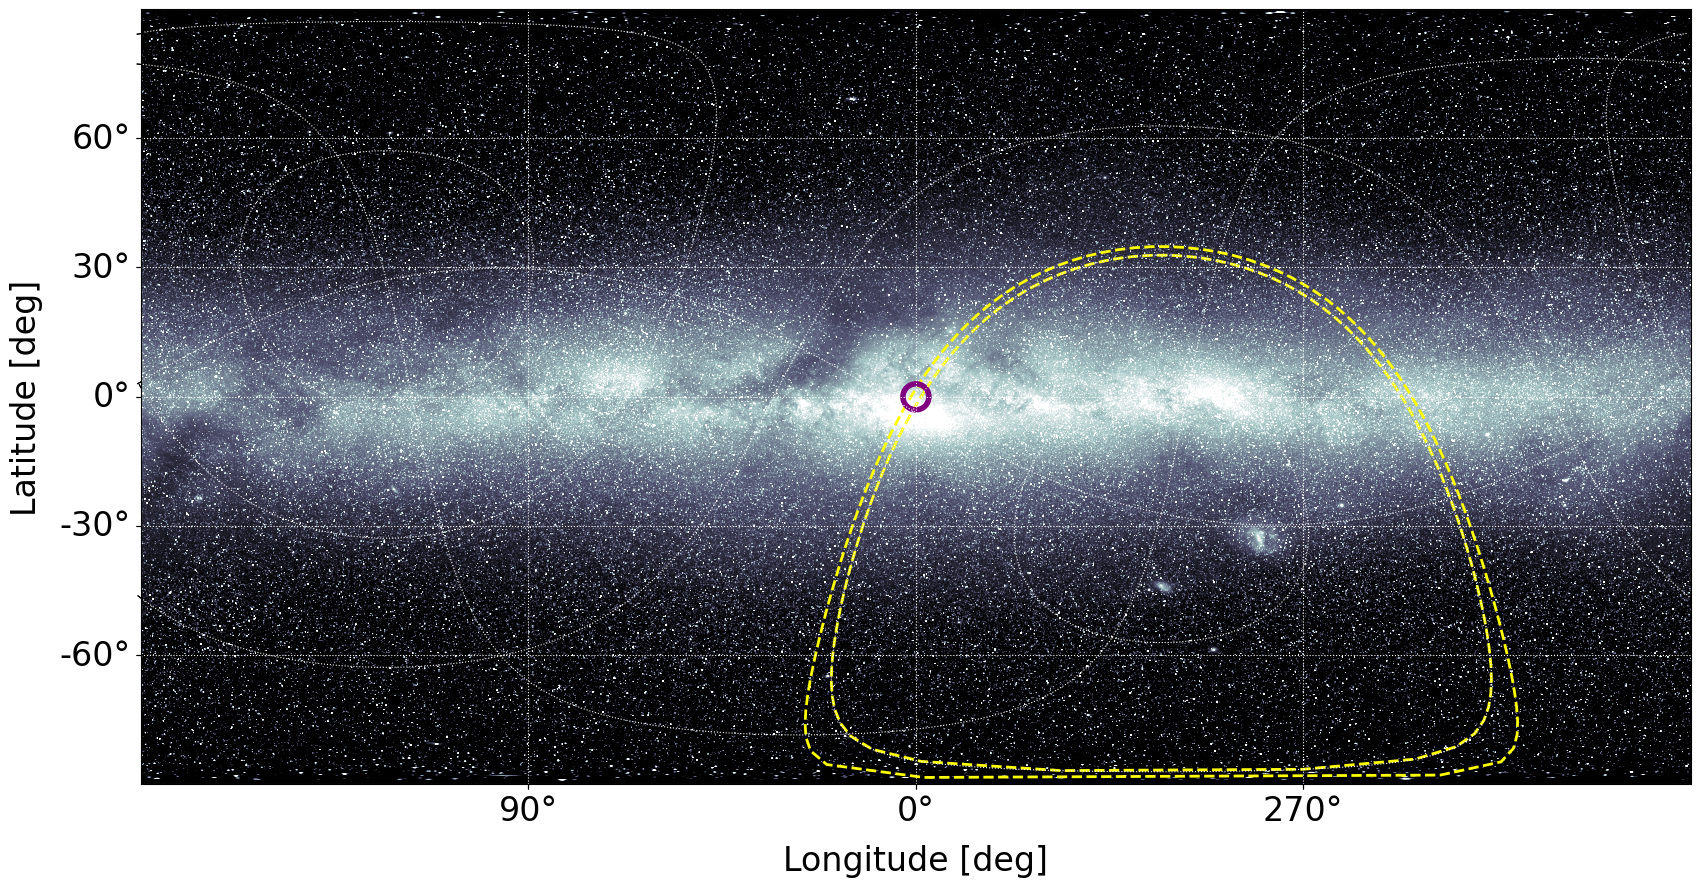

In [20]:
fig = plt.figure(figsize=(20,20))
rcParams.update({'font.size': 24})
ax = plt.subplot(projection=w, slices=('x','y',0))
ax.coords.grid(True, color='white', ls='dotted')
plt.imshow(dat[1],norm=c.LogNorm(vmin=50,vmax=.7e3),cmap='bone')
# plt.colorbar()
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_xlim([0,3600])
ax.set_ylim([0,1800])

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')

# ax.scatter(ras, decs, transform=ax.get_transform('fk5'), s=10,
#            facecolor='white')

# circ = Circle((srcCoord.ra.value,srcCoord.dec.value), 1, edgecolor='red',facecolor='red',transform=ax.get_transform('fk5'))
# ax.add_patch(circ)

r = Quadrangle((srcCoord.ra.value-3,srcCoord.dec.value-1)*u.deg, 360*u.deg, 2*u.deg,
               edgecolor='yellow', facecolor='none', linewidth=2, linestyle='dashed',
               transform=ax.get_transform('fk5'))
ax.add_patch(r)

ax.scatter(srcCoord.ra, srcCoord.dec, transform=ax.get_transform('fk5'), s=350, edgecolor='purple', facecolor='none',linewidth=4)


In [25]:
# from reproject import reproject_to_healpix

In [21]:
# reproject_to_healpix(dat[0],w.to_header)

In [22]:
# dat[0].shape

In [37]:
# dat[1].shape

(1800, 3600)